In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# import ensemble methods
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from xgboost import XGBClassifier

# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(
    "ignore", category=DeprecationWarning
)  # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=[
        "#4B9AC7",
        "#4BE8E0",
        "#9DD4F3",
        "#97FBF6",
        "#2A7FAF",
        "#23B1AB",
        "#0E3449",
        "#015955",
    ]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"  # to be replaced by "iframe" if working on JULIE

In [2]:
df = pd.read_csv('conversion_data_train.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
df.shape

(284580, 6)

In [4]:
df.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


### LOGISTIC REGRESSION WITH NEW_USER CATEGORICAL FEATURE, NOT NUMERICAL

In [9]:
target_variable = 'converted'
X = df.drop([target_variable, 'age'], axis=1)
y = df[target_variable]


In [12]:
numerical_features = ['total_pages_visited']
categorical_features = ['country', 'new_user', 'source']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# numerical_imputer = SimpleImputer(strategy='mean') mais pas besoin car pas de valeurs manquantes
numerical_scaler = StandardScaler()

# categorical_imputer = SimpleImputer(strategy='constant', fill_value='UNKNOWN') mais pas besoin car pas de valeurs manquantes
categorical_encoder = OneHotEncoder(drop='first')

# Group our transformers

numeric_pipeline = Pipeline([
  #('numeric_imputer', numerical_imputer),
  ('numeric_scaler', numerical_scaler)
])

categoric_pipeline = Pipeline([
  #('categoric_imputer', categorical_imputer),
  ('categoric_encoder', categorical_encoder)
])

preprocessor = ColumnTransformer([
  ('numeric_pipeline', numeric_pipeline, numerical_features),
  ('categoric_pipeline', categoric_pipeline, categorical_features),
])

In [15]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [22]:
reg_log = LogisticRegression()
reg_log.fit(X_train, y_train)


y_train_pred = reg_log.predict(X_train)
y_test_pred = reg_log.predict(X_test)

print(f"Accuracy on train set is {accuracy_score(y_train, y_train_pred)}")
print(f"f1_score on train set is {f1_score(y_train, y_train_pred)}")
print(f"Accuracy on test set is {accuracy_score(y_test, y_test_pred)}")
print(f"f1_score on test set is {f1_score(y_test, y_test_pred)}")

from sklearn.metrics import precision_score, recall_score
print(f"Precision score is {precision_score(y_test, y_test_pred)}") #proportion de vrais positifs parmi tous les positifs PREDITS
print(f"Recall score is {recall_score(y_test, y_test_pred)}")#propostion de vrais positifs détectés parmis tous les positifs REELS


Accuracy on train set is 0.9854829924801461
f1_score on train set is 0.74811371084521
Accuracy on test set is 0.985996907723663
f1_score on test set is 0.7566412213740458
Precision score is 0.8610145934676859
Recall score is 0.6748366013071896


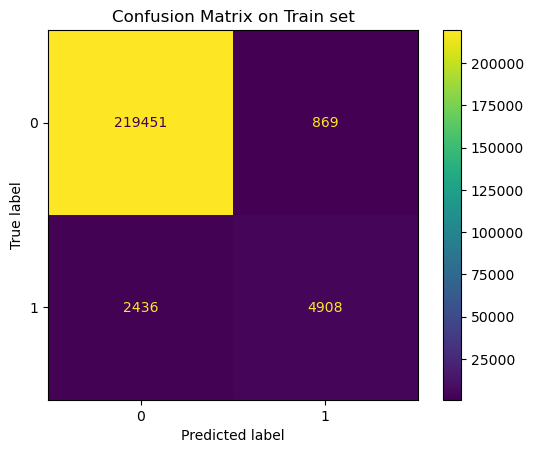

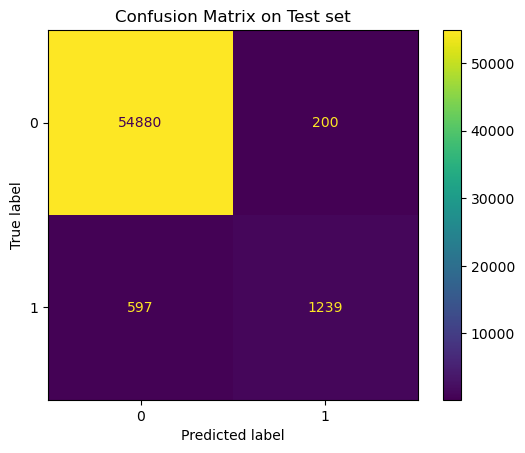

In [18]:
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    reg_log, X_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    reg_log, X_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

### BAGGING CLASSIFIER

In [25]:
bagging = BaggingClassifier(estimator=reg_log, n_estimators=5, random_state=42)

bagging.fit(X_train, y_train)

y_train_pred_bag = bagging.predict(X_train)
y_test_pred_bag = bagging.predict(X_test)


print(f"Accuracy on train set is {accuracy_score(y_train, y_train_pred_bag)}")
print(f"f1_score on train set is {f1_score(y_train, y_train_pred_bag)}")
print(f"Accuracy on test set is {accuracy_score(y_test, y_test_pred_bag)}")
print(f"f1_score on test set is {f1_score(y_test, y_test_pred_bag)}")

from sklearn.metrics import precision_score, recall_score
print(f"Precision score is {precision_score(y_test, y_test_pred_bag)}") #proportion de vrais positifs parmi tous les positifs PREDITS
print(f"Recall score is {recall_score(y_test, y_test_pred_bag)}")


Accuracy on train set is 0.9854829924801461
f1_score on train set is 0.74811371084521
Accuracy on test set is 0.985996907723663
f1_score on test set is 0.7566412213740458
Precision score is 0.8610145934676859
Recall score is 0.6748366013071896


### RANDOM FOREST

In [28]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(criterion='entropy')
RF.fit(X_train, y_train)

y_train_pred_RF = RF.predict(X_train)
y_test_pred_RF = RF.predict(X_test)


print(f"Accuracy on train set is {accuracy_score(y_train, y_train_pred_RF)}")
print(f"f1_score on train set is {f1_score(y_train, y_train_pred_RF)}")
print(f"Accuracy on test set is {accuracy_score(y_test, y_test_pred_RF)}")
print(f"f1_score on test set is {f1_score(y_test, y_test_pred_RF)}")

from sklearn.metrics import precision_score, recall_score
print(f"Precision score is {precision_score(y_test, y_test_pred_RF)}") #proportion de vrais positifs parmi tous les positifs PREDITS
print(f"Recall score is {recall_score(y_test, y_test_pred_RF)}")


Accuracy on train set is 0.9856015883055731
f1_score on train set is 0.756318763009218
Accuracy on test set is 0.9855576639257854
f1_score on test set is 0.7555026769779893
Precision score is 0.8322411533420708
Recall score is 0.6917211328976035


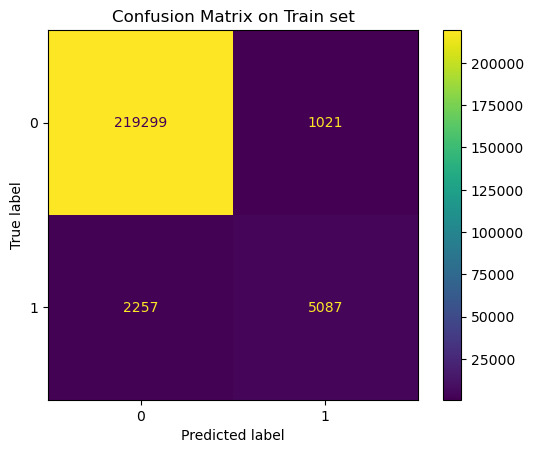

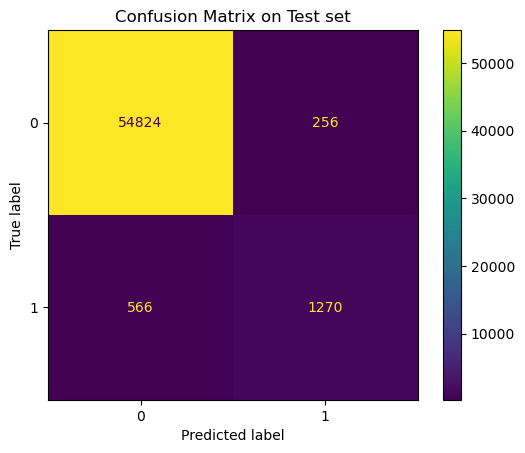

In [29]:
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    RF, X_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    RF, X_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

### RANDOM FOREST WITH GRID SEARCH

In [33]:
RF_GS = RandomForestClassifier()

# Grid of values to be tested
params = {
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 4, 8],
    "n_estimators": [10, 20, 40],
}
gridsearch = GridSearchCV(
    RF_GS, param_grid=params, cv=5
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
Best validation accuracy :  0.9854214996785882


In [34]:
y_train_pred_RF_GS = gridsearch.predict(X_train)
y_test_pred_RF_GS = gridsearch.predict(X_test)


print(f"Accuracy on train set is {accuracy_score(y_train, y_train_pred_RF_GS)}")
print(f"f1_score on train set is {f1_score(y_train, y_train_pred_RF_GS)}")
print(f"Accuracy on test set is {accuracy_score(y_test, y_test_pred_RF_GS)}")
print(f"f1_score on test set is {f1_score(y_test, y_test_pred_RF_GS)}")

from sklearn.metrics import precision_score, recall_score
print(f"Precision score is {precision_score(y_test, y_test_pred_RF_GS)}") #proportion de vrais positifs parmi tous les positifs PREDITS
print(f"Recall score is {recall_score(y_test, y_test_pred_RF_GS)}")

Accuracy on train set is 0.9855928034296155
f1_score on train set is 0.7540491901619676
Accuracy on test set is 0.9857509311968515
f1_score on test set is 0.7566756675667566
Precision score is 0.8423513694054776
Recall score is 0.6868191721132898


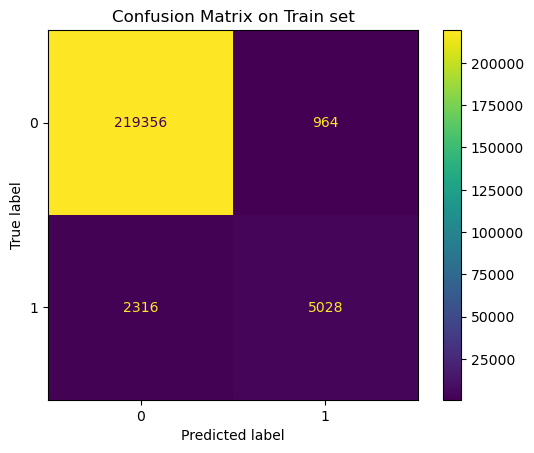

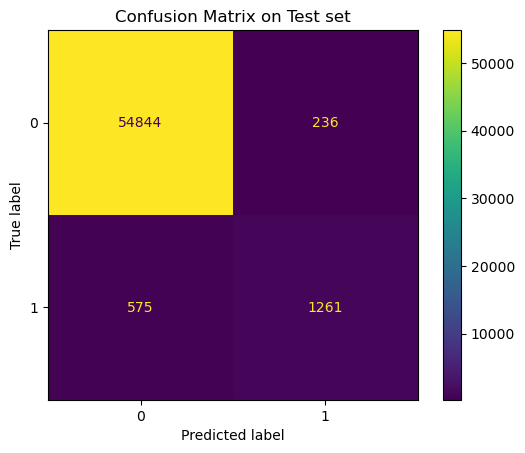

In [36]:
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    gridsearch, X_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    gridsearch, X_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

## TEST

In [37]:


X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test)

gridsearch.fit(X, y)
df_test = pd.read_csv('conversion_data_test.csv')
X_without_labels = df_test.drop(['age'], axis=1)
X_without_labels = preprocessor.transform(X_without_labels)

gridsearch.predict(X_without_labels)



array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [38]:
data = {
    'converted': gridsearch.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_Clement-tikitaka.csv', index=False)